## Imports

In [275]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import pprint
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import re
import seaborn
from tqdm import tqdm
tqdm.pandas()

In [276]:
train_data = pd.read_csv('./663e2b6d54457_train_data_with_samplefeatures.csv')
match_data = pd.read_csv('./664389efa0868_match_level_scorecard.csv')
bowlers_data = pd.read_csv('./663e2b2c60743_bowler_level_scorecard.csv')
batsman_data = pd.read_csv('./663e2b548c98c_batsman_level_scorecard.csv')
test_data = pd.read_csv('./6644a1e287df6_test_data_with_samplefeatures.csv')

#Don't change original dataframes
train_data_o = pd.read_csv('./663e2b6d54457_train_data_with_samplefeatures.csv')
match_data_o = pd.read_csv('./664389efa0868_match_level_scorecard.csv')
bowlers_data_o = pd.read_csv('./663e2b2c60743_bowler_level_scorecard.csv')
batsman_data_o = pd.read_csv('./663e2b548c98c_batsman_level_scorecard.csv')
test_data_o = pd.read_csv('./6644a1e287df6_test_data_with_samplefeatures.csv')

In [277]:
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)
match_data['team1_bat_inning'] = np.where( ((match_data['team1']==match_data['toss winner'])&(match_data['toss decision']=='bat'))|\
                                               ((match_data['team2']==match_data['toss winner'])&(match_data['toss decision']=='field')) , 1, 2)


## Helper Functions

In [278]:
## Plot

In [279]:
from matplotlib import pyplot as plt
seaborn.set_theme()
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5))
    plt.bar(ind, blue_bar, label='Team 1 win%')
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins')
    plt.ylabel('Win %')
    plt.title(f'RnP - {feature} vs win')
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks'])
    plt.ylim([ylim_lb,ylim_ub])
    plt.legend(loc='best')
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show()



In [280]:

def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_data
        id_col = 'batsman_id'
    else:
        df_topick = bowlers_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)



In [588]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb

def preprocess_and_train(df, n_trees = 10, depth = 2, lr = 0.1, gridsearch = False, eta = 0.1,colsample_bytree=0.6, gamma = 0.01, subsample=0.8,reg_lambda=0.8,num_boosting_rounds=50):
    # Remove any column with object datatype
    df = df.select_dtypes(exclude=['object'])

    # Separate features and target variable
    X = df.drop(columns=['winner_01','winner_id','match id']).fillna(0)
    y = df['winner_01']


    if not gridsearch:
    # Create a pipeline with preprocessor and Gradient Boosting Classifier
        pipeline =xgb.XGBClassifier(n_estimators = num_boosting_rounds, learning_rate=eta,max_depth=depth,gamma=gamma, subsample=subsample,colsample_bytree=colsample_bytree,reg_lambda=reg_lambda)
        pipeline.fit(X, y)

        # Get the best estimator
        best_model = pipeline

        # Perform cross-validation on the best estimator and get the classification report
        y_pred = cross_val_score(best_model, X, y, cv=5, scoring='f1')
        print(y_pred)
        #print(y_pred)
        # Split the data for a final evaluation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        
        report = classification_report(y_test, y_pred)
        print(report)


        return best_model
    else:
        
        param_grid = {
            'n_estimators':[3,5,10,15,20,25,50,60],
            'learning_rate':[0.05, 0.1, 0.2, 0.8, 0.01],
            'max_depth': [2,3,4,5,10,6]
        }


        clf = GradientBoostingClassifier()
        search =GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy',cv=5,verbose=3)

        search.fit(X, y)

        best_params = search.best_params_
        print(best_params)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(cross_val_score(clf,X,y,cv=10,scoring='f1'))
        
        report = classification_report(y_test, y_pred)
        print(report)
        clf.fit(X,y)

        return clf


def get_data_ready(df,winpresent):
    df = df.select_dtypes(exclude=['object'])
    if winpresent:
        X = df.drop(columns=['winner_01','winner_id', 'match id']).fillna(0)
        y = df['winner_01']
        return X,y
    else:
        df.drop('match id',axis=1, inplace=True)
        X = df.copy().fillna(0)
        return X


## Half Centuries

In [282]:
def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.



In [283]:
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

100%|██████████| 948/948 [00:48<00:00, 19.39it/s]


In [284]:
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

slope: 0.6 / 0.39 =  1.53


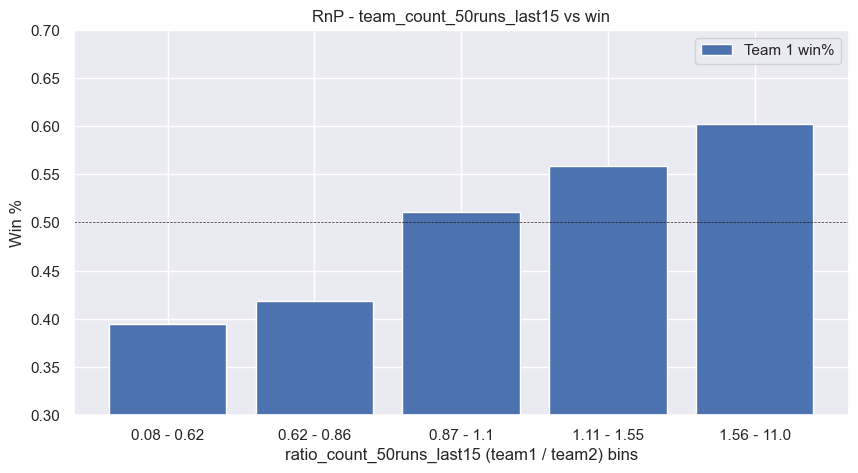

In [285]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15', N=5)

In [286]:
test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 271/271 [00:15<00:00, 17.87it/s]


(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,...,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:259025...,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:161387...,Ud Ss of Aa,field,Bo Ac Cb,...,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188...,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:315072...,Ja Ts,field,Pe Sm Ga,...,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


## win percent

In [287]:
def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_data[(match_data['match_dt']<date)&\
                      ((match_data['team1_id']==team_id)|(match_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [288]:
# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 5), axis=1)


# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns


100%|██████████| 948/948 [00:02<00:00, 419.27it/s]


In [289]:
test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n=5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n=5), axis=1)
test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)

  0%|          | 0/271 [00:00<?, ?it/s]

100%|██████████| 271/271 [00:00<00:00, 411.32it/s]


(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,...,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:259025...,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:161387...,Ud Ss of Aa,field,Bo Ac Cb,...,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188...,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:315072...,Ja Ts,field,Pe Sm Ga,...,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


slope: 0.58 / 0.4 =  1.47


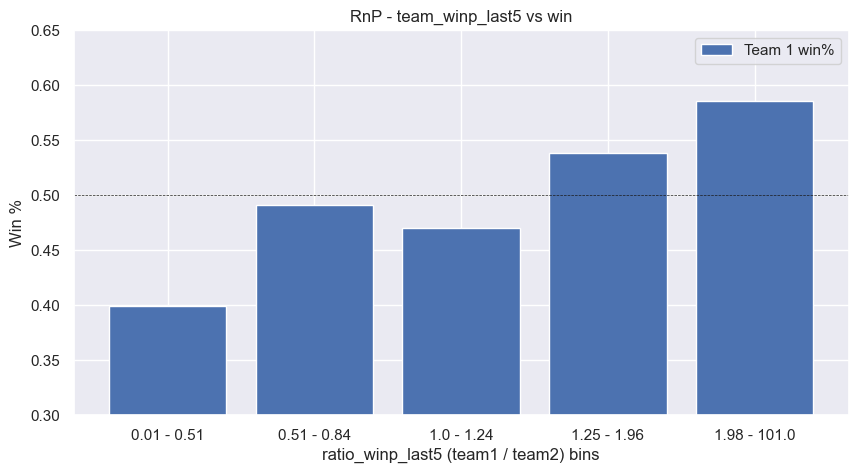

In [290]:
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)

## Average Run

In [291]:
def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_data[(match_data['match_dt']<date)&\
                      ((match_data['team1_id']==team_id)|(match_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.


In [292]:
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
train_data['team2only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)


train_data['team_avg_runs_last15'] = (train_data['team1only_avg_runs_last15']+1)/(train_data['team2only_avg_runs_last15']+1)
train_data.drop(columns=['team2only_avg_runs_last15', 'team2only_avg_runs_last15'], inplace=True) # drop intermediate columns


100%|██████████| 948/948 [00:05<00:00, 177.12it/s]


In [293]:
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
test_data['team2only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)


test_data['team_avg_runs_last15'] = (test_data['team1only_avg_runs_last15']+1)/(test_data['team2only_avg_runs_last15']+1)
test_data.drop(columns=['team2only_avg_runs_last15', 'team2only_avg_runs_last15'], inplace=True) # drop intermediate columns


100%|██████████| 271/271 [00:01<00:00, 183.41it/s]


slope: 0.49 / 0.44 =  1.12


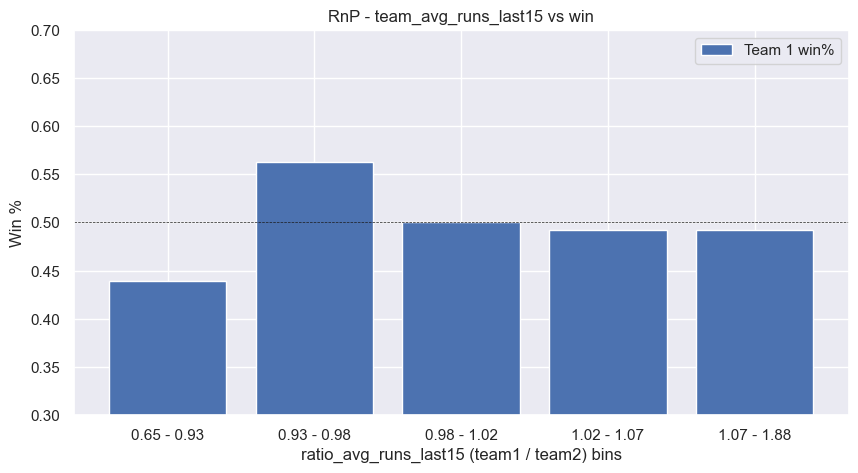

In [294]:
createRnP(train_data, 'team_avg_runs_last15')

## Cross win percentages

In [295]:
def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_data[(match_data['match_dt']<date)&\
                      (((match_data['team1_id']==team1_id)&(match_data['team2_id']==team2_id))|((match_data['team1_id']==team2_id)&(match_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


In [296]:
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 948/948 [00:02<00:00, 385.20it/s]


In [297]:
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 271/271 [00:00<00:00, 367.36it/s]


slope: 0.52 / 0.45 =  1.16


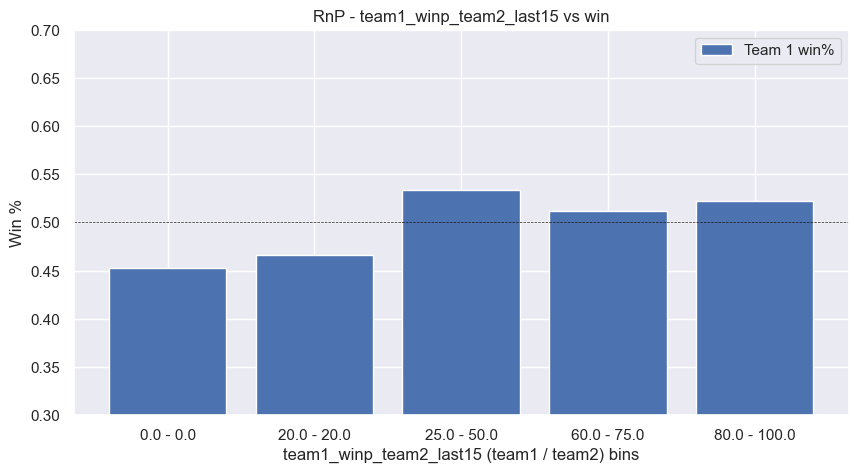

In [298]:
createRnP(train_data, 'team1_winp_team2_last15')

## Diff Runs for given ground

In [299]:
def diffRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_data[(match_data['match_dt']<date)&(match_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']-df_rel['inning2_runs']) # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.

In [300]:
## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_diff_runs_last15'] = train_data.progress_apply(lambda x: \
                                  diffRunsGround(x['ground_id'], x['match_dt'], 15,), axis=1)

100%|██████████| 948/948 [00:02<00:00, 401.65it/s]


In [301]:
## Similarly for test data.
test_data['ground_diff_runs_last15'] = test_data.progress_apply(lambda x: \
                                  diffRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)

100%|██████████| 271/271 [00:00<00:00, 416.70it/s]


slope: 0.52 / 0.49 =  1.06


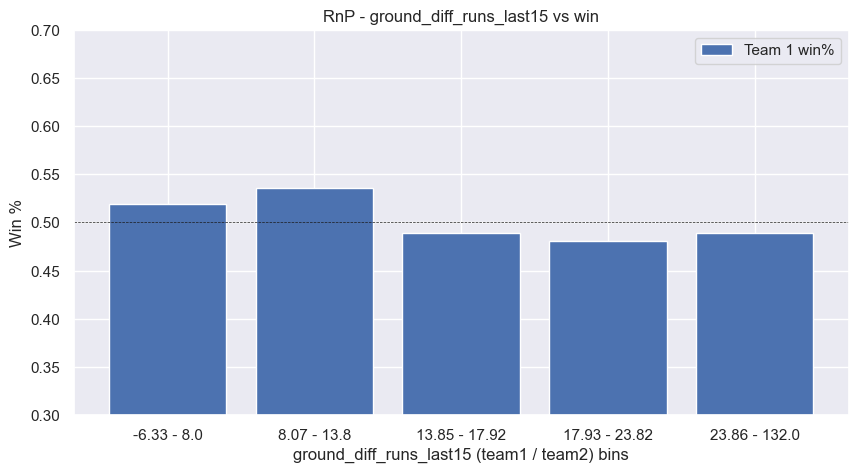

In [302]:
createRnP(train_data,'ground_diff_runs_last15')

## Avg runs Ground

In [303]:
def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_data[(match_data['match_dt']<date)&(match_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_data[(match_data['match_dt']<date)&(match_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.

In [304]:
## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)

100%|██████████| 948/948 [00:02<00:00, 406.50it/s]


In [305]:
## Similarly for test data.
test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)

100%|██████████| 271/271 [00:00<00:00, 375.71it/s]


slope: 0.5 / 0.45 =  1.1


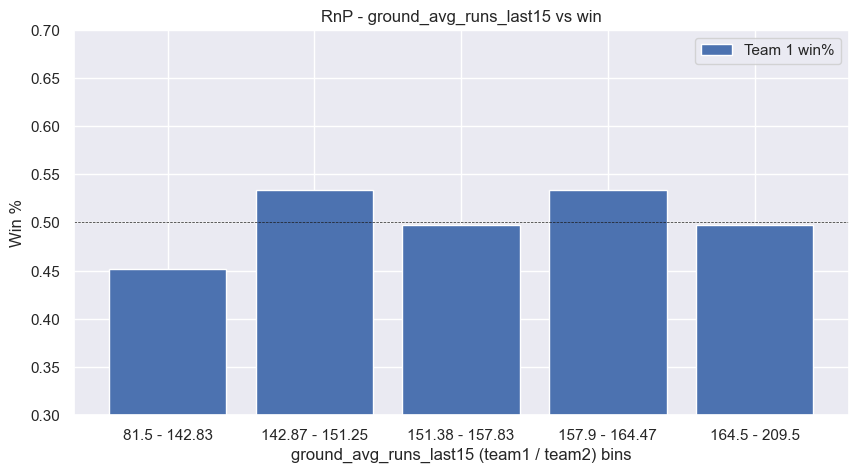

In [306]:
createRnP(train_data,'ground_avg_runs_last15')

In [307]:
preprocess_and_train(train_data)

              precision    recall  f1-score   support

           0       0.58      0.63      0.60        99
           1       0.55      0.51      0.53        91

    accuracy                           0.57       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.57      0.57      0.57       190



## Ground_wickets_last_5



In [308]:
def calculate_ground_wickets_last_5(ground_id, matches, bowlers_data, date, last_n=5):
    """
    Calculate the average number of wickets taken in the last n matches at a given ground.
    
    Parameters:
    ground_id (str): The ID or name of the ground.
    match_data (DataFrame): DataFrame containing match-level data.
    bowlers_data (DataFrame): DataFrame containing bowler-level data.
    date
    last_n (int): The number of recent matches to consider.
    
    Returns:
    float: The average number of wickets taken in the last n matches at the specified ground.
    """
    # Filter matches for the specified ground
    ground_matches = matches[(match_data['match_dt']<date)&(match_data['ground_id'] == ground_id)].sort_values(by='match_dt', ascending=True)
    if ground_matches.empty:
        return np.nan
    
    # Get the match IDs for the filtered matches
    match_ids = ground_matches['match id'].unique()
    
    # Filter bowlers data for these match IDs
    ground_bowlers = bowlers_data[bowlers_data['match id'].isin(match_ids)]
    
    # Sum the wickets taken by bowlers in these matches
    avg_wickets = ground_bowlers['wicket_count'].mean()
    
    return avg_wickets

# Applying the function to the dataset
train_data['ground_avg_wickets'] = train_data.progress_apply(lambda row: calculate_ground_wickets_last_5(row['ground_id'], match_data, bowlers_data, row['match_dt']), axis=1)


100%|██████████| 948/948 [00:02<00:00, 401.89it/s]


In [309]:
test_data['ground_avg_wickets'] = test_data.progress_apply(lambda row: calculate_ground_wickets_last_5(row['ground_id'], match_data, bowlers_data, row['match_dt']), axis=1)


100%|██████████| 271/271 [00:00<00:00, 373.56it/s]


slope: 0.49 / 0.49 =  1.0


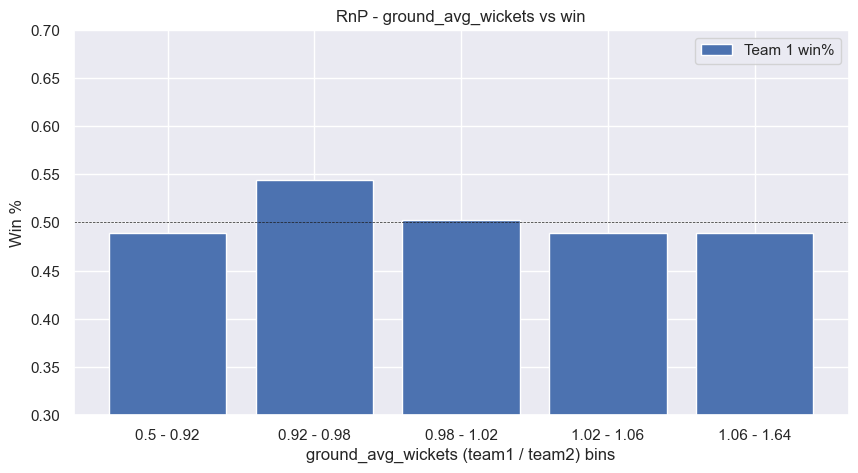

In [310]:
createRnP(train_data,'ground_avg_wickets')

In [311]:
preprocess_and_train(train_data)

              precision    recall  f1-score   support

           0       0.55      0.58      0.56        99
           1       0.51      0.48      0.50        91

    accuracy                           0.53       190
   macro avg       0.53      0.53      0.53       190
weighted avg       0.53      0.53      0.53       190



## Ratio of match played


In [312]:
def total_matches_played_by_team(team_players, date):
    """
    Calculate the total number of matches played by all players in a team before the given date.
    
    Parameters:
    team_players (list): List of player IDs in the team.
    date (str): Date to look-back and get historical match data.
    
    Returns:
    int: Total number of matches played by the team.
    """
    total_matches = 0
    for player_id in team_players:
        # Retrieve last n games stats for the player (both batting and bowling)
        batting_stats = giveLastNgamesPlayer(player_id, date, n=1000, bat_or_bowl='bat')
        bowling_stats = giveLastNgamesPlayer(player_id, date, n=1000, bat_or_bowl='bowl')
        
        # Sum the number of matches played
        total_matches += len(batting_stats) + len(bowling_stats)
    
    return total_matches

def calculate_matches_ratio(row):
    """
    Calculate the ratio of total number of matches played by team 1 players to total number of matches played by team 2 players.
    
    Parameters:
    row (Series): Row of the DataFrame containing match data.
    
    Returns:
    float: Ratio of total matches played by team 1 players to team 2 players.
    """
    date = row['match_dt']
    team1_players = row['team1_roster_ids'].split(':')
    team2_players = row['team2_roster_ids'].split(':')
    
    team1_total_matches = total_matches_played_by_team(team1_players, date)
    team2_total_matches = total_matches_played_by_team(team2_players, date)
    
    if team2_total_matches == 0:
        return np.nan
    
    return team1_total_matches / team2_total_matches

# Assuming team1_players and team2_players columns contain lists of player IDs
train_data['matches_ratio_team1_team2'] = train_data.progress_apply(calculate_matches_ratio, axis=1)


100%|██████████| 948/948 [02:28<00:00,  6.40it/s]


In [313]:
test_data['matches_ratio_team1_team2'] = test_data.progress_apply(calculate_matches_ratio, axis=1)


100%|██████████| 271/271 [00:45<00:00,  5.92it/s]


slope: 0.6 / 0.33 =  1.8


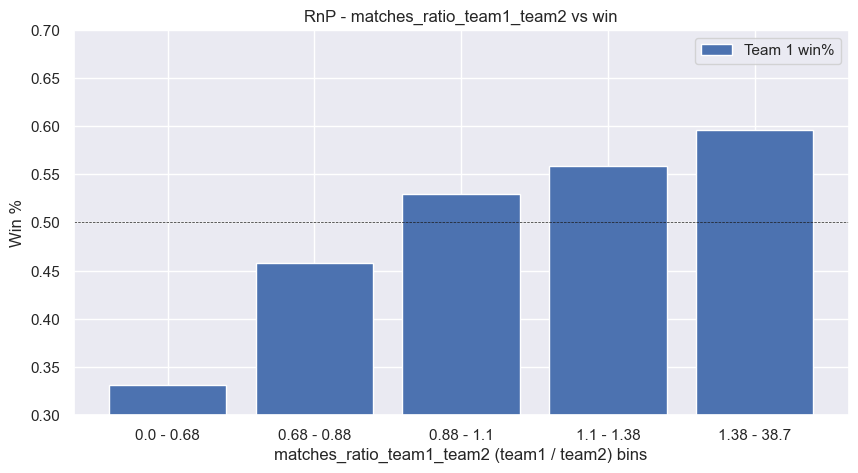

In [314]:
createRnP(train_data,'matches_ratio_team1_team2')

In [315]:
preprocess_and_train(train_data)

              precision    recall  f1-score   support

           0       0.62      0.61      0.61        99
           1       0.58      0.59      0.59        91

    accuracy                           0.60       190
   macro avg       0.60      0.60      0.60       190
weighted avg       0.60      0.60      0.60       190



##AVG_TOP5


In [316]:
def get_top_n_avg_recent_runs(player_ids, date, n=5, last_n_games=10):
    """
    Calculate the average recent runs for the top n players in a team.
    
    Parameters:
    player_ids (list): List of player IDs in the team.
    date (str): Date to look-back and get historical match data.
    n (int): Number of top players to consider.
    last_n_games (int): Number of recent games to consider for each player.
    
    Returns:
    float: Average recent runs for the top n players.
    """
    recent_runs = []
    
    for player_id in player_ids:
        batting_stats = giveLastNgamesPlayer(player_id, date, last_n_games, 'bat')
        total_runs = batting_stats['runs'].sum()
        recent_runs.append(total_runs)
    
    # Sort runs in descending order and take the top n scores
    top_n_runs = sorted(recent_runs, reverse=True)[:n]
    
    if not top_n_runs:
        return 0.0
    
    return sum(top_n_runs) / len(top_n_runs)



def calculate_avg_recent_runs_ratio(row,date):
    """
    Calculate the ratio of the average recent runs by the top 5 players of team 1 to team 2.
    
    Parameters:
    row (Series): Row of the DataFrame containing match data.
    
    Returns:
    float: Ratio of average recent runs by top 5 players of team 1 to team 2.
    """
    date = row['match_dt']
    team1_players = row['team1_roster_ids'].split(':')
    team2_players = row['team2_roster_ids'].split(':')
    
    team1_avg_recent_runs = get_top_n_avg_recent_runs(team1_players, date, n=5)
    team2_avg_recent_runs = get_top_n_avg_recent_runs(team2_players, date, n=5)
    
    return (team1_avg_recent_runs + 1e-2) / (team2_avg_recent_runs + 1e-2)

# Applying the function to the dataset
train_data['avg_recent_runs_ratio'] = train_data.progress_apply(lambda x:calculate_avg_recent_runs_ratio(x,x['match_dt']), axis=1)


100%|██████████| 948/948 [01:23<00:00, 11.35it/s]


In [317]:
test_data['avg_recent_runs_ratio'] = test_data.progress_apply(lambda x:calculate_avg_recent_runs_ratio(x,x['match_dt']), axis=1)


100%|██████████| 271/271 [00:22<00:00, 11.89it/s]


slope: 0.63 / 0.42 =  1.5


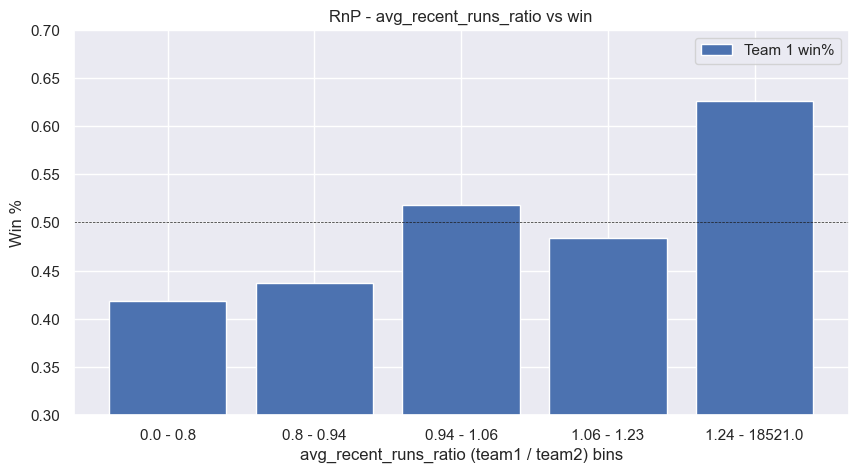

In [318]:
createRnP(train_data,'avg_recent_runs_ratio')

In [319]:
preprocess_and_train(train_data, depth = 5, n_trees = 20, lr=0.05)

              precision    recall  f1-score   support

           0       0.59      0.52      0.55        99
           1       0.53      0.60      0.57        91

    accuracy                           0.56       190
   macro avg       0.56      0.56      0.56       190
weighted avg       0.56      0.56      0.56       190



## Avg_Wicket_Ratio


In [320]:
def get_top_n_avg_recent_wickets(player_ids, date, n=5, last_n_games=10):
    recent_wickets = []
    
    for player_id in player_ids:
        bowling_stats = giveLastNgamesPlayer(player_id, date, last_n_games, 'bowl')
        total_wickets = bowling_stats['wicket_count'].sum()
        recent_wickets.append(total_wickets)
    
    # Sort wickets in descending order and take the top n counts
    top_n_wickets = sorted(recent_wickets, reverse=True)[:n]
    
    if not top_n_wickets:
        return 0.0
    
    return sum(top_n_wickets) / len(top_n_wickets)

def calculate_avg_recent_wickets_ratio(row):
    date = row['match_dt']
    team1_players = row['team1_roster_ids'].split(':')
    team2_players = row['team2_roster_ids'].split(':')
    
    team1_avg_recent_wickets = get_top_n_avg_recent_wickets(team1_players, date, n=5)
    team2_avg_recent_wickets = get_top_n_avg_recent_wickets(team2_players, date, n=5)
    
    return (team1_avg_recent_wickets + 1e-2) / (team2_avg_recent_wickets + 1e-2)

# Applying the function to the dataset
train_data['avg_recent_wickets_ratio'] = train_data.progress_apply(calculate_avg_recent_wickets_ratio, axis=1)


100%|██████████| 948/948 [01:04<00:00, 14.59it/s]


In [321]:
test_data['avg_recent_wickets_ratio'] = test_data.progress_apply(calculate_avg_recent_wickets_ratio, axis=1)


100%|██████████| 271/271 [00:18<00:00, 14.43it/s]


slope: 0.58 / 0.43 =  1.35


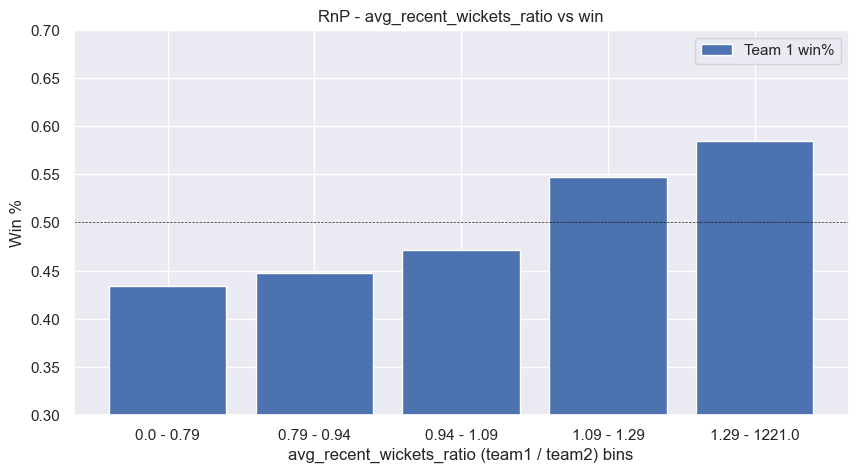

In [322]:
createRnP(train_data,'avg_recent_wickets_ratio')

In [323]:
preprocess_and_train(train_data, depth=2,lr=0.1,n_trees=3)

              precision    recall  f1-score   support

           0       0.65      0.48      0.55        99
           1       0.56      0.71      0.63        91

    accuracy                           0.59       190
   macro avg       0.60      0.60      0.59       190
weighted avg       0.61      0.59      0.59       190



In [324]:

def count_batsmen(row,var):
    '''
    Function to count the number of batsmen in a given roster.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    
    Output- None
    
    Returns- int value denoting count of batsmen in the roster.
    '''
    player_list = row[var]
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    batsmen_count = 0
    for player in player_list: # loop over each player_id in roster
        mask = ((batsman_data['batsman_id'] == float(player)) & (batsman_data['match_dt']<row['match_dt']))
        if mask.any():
            if (batsman_data[mask].iloc[:,0].count())>10:
                batsmen_count += 1
    return batsmen_count

# Apply the function to calculate the number of batsmen for each team in each match
train_data['team1_batsmen_count'] = train_data.progress_apply(lambda x: count_batsmen(x,'team1_roster_ids'),axis=1)
train_data['team2_batsmen_count'] = train_data.progress_apply(lambda x: count_batsmen(x,'team2_roster_ids'),axis=1)

# Calculate the ratio of team1 batsmen count to team2 batsmen count
train_data['batsmen_count_ratio'] = (train_data['team1_batsmen_count']+0.01) / (train_data['team2_batsmen_count']+0.01)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_batsmen_count', 'team2_batsmen_count'], inplace=True)

100%|██████████| 948/948 [00:31<00:00, 30.53it/s]


In [351]:
test_data['team1_batsmen_count'] = test_data.progress_apply(lambda x: count_batsmen(x,'team1_roster_ids'),axis=1)
test_data['team2_batsmen_count'] = test_data.progress_apply(lambda x: count_batsmen(x,'team2_roster_ids'),axis=1)
test_data['batsmen_count_ratio'] = (test_data['team1_batsmen_count']+0.01) / (test_data['team2_batsmen_count']+0.01)
test_data.drop(columns=['team1_batsmen_count', 'team2_batsmen_count'], inplace=True)


100%|██████████| 271/271 [00:04<00:00, 54.37it/s]


slope: 0.65 / 0.25 =  2.58


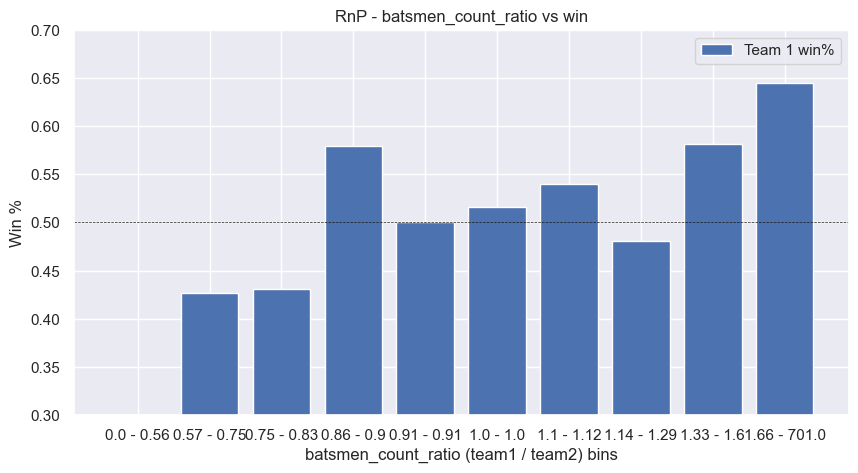

In [ ]:
createRnP(train_data,'batsmen_count_ratio', N=10)

In [327]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=44)

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        99
           1       0.53      0.49      0.51        91

    accuracy                           0.55       190
   macro avg       0.55      0.55      0.54       190
weighted avg       0.55      0.55      0.55       190



##Toss_win_rate

In [328]:
def toss_win_rate(team_id, date):
    '''
    Function to calculate the win rate of a team when they win the toss.
    
    Input-
    1. team_id: ID of the team.
    2. date: Match date to calculate the feature up to.
    
    Output- None
    
    Returns- Float value denoting win rate of the team when they win the toss.
    '''
    # Filter matches where the team won the toss before the given date
    df_rel = match_data[(match_data['match_dt'] < date) & (match_data['toss winner'] == team_id)]
    # Calculate the win rate
    if df_rel.empty:
        return 0
    win_count = df_rel[df_rel['winner'] == team_id].shape[0]
    return win_count / df_rel.shape[0]

# Apply the function to calculate win rates for team1 and team2 when they win the toss
train_data['team1_toss_win_rate'] = train_data.progress_apply(lambda x: toss_win_rate(x['team1'], x['match_dt']), axis=1)
train_data['team2_toss_win_rate'] = train_data.progress_apply(lambda x: toss_win_rate(x['team2'], x['match_dt']), axis=1)

# Calculate the ratio of win rates
train_data['toss_win_rate_ratio'] = (train_data['team1_toss_win_rate'] + 1e-2) / (train_data['team2_toss_win_rate'] + 1e-2)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_toss_win_rate', 'team2_toss_win_rate'], inplace=True)

100%|██████████| 948/948 [00:01<00:00, 593.07it/s]


In [350]:
test_data['team1_toss_win_rate'] = test_data.progress_apply(lambda x: toss_win_rate(x['team1'], x['match_dt']), axis=1)
test_data['team2_toss_win_rate'] = test_data.progress_apply(lambda x: toss_win_rate(x['team2'], x['match_dt']), axis=1)

test_data['toss_win_rate_ratio'] = (test_data['team1_toss_win_rate'] + 1e-2) / (test_data['team2_toss_win_rate'] + 1e-2)
test_data.drop(columns=['team1_toss_win_rate', 'team2_toss_win_rate'], inplace=True)


100%|██████████| 271/271 [00:00<00:00, 1454.39it/s]


slope: 0.52 / 0.4 =  1.29


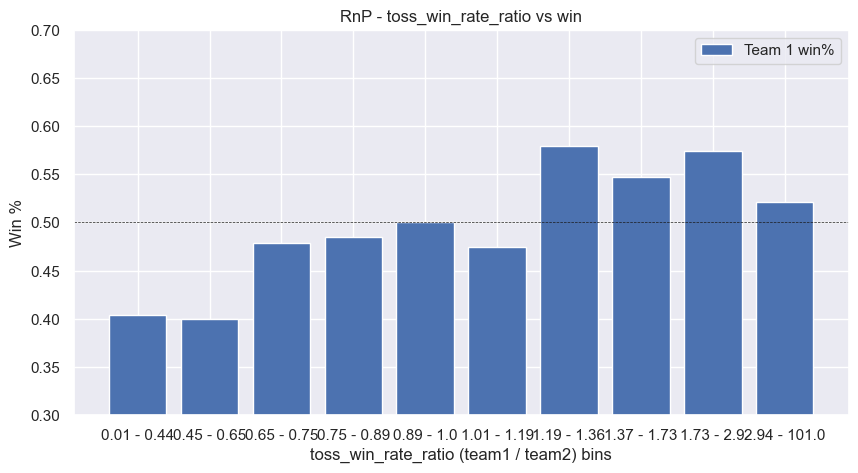

In [330]:
createRnP(train_data,'toss_win_rate_ratio', N=10)

In [331]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=44)

              precision    recall  f1-score   support

           0       0.57      0.59      0.58        99
           1       0.54      0.53      0.53        91

    accuracy                           0.56       190
   macro avg       0.56      0.56      0.56       190
weighted avg       0.56      0.56      0.56       190



##Bowler_Count


In [380]:
def count_bowlers(player_list, date):
    '''
    Function to get the count of bowlers in the roster of a team before an input date.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    
    Output-None
    
    Returns- int value denoting count of bowlers in the roster.
    '''
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    bowler_count = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = bowlers_data[(bowlers_data['match_dt']<date) & (bowlers_data['bowler_id']==float(player))] # getting bowling stats before the match date for each player.
        if df_rel.count().iloc[0] < 10:
            continue
        if not df_rel.empty:
            bowler_count += 1
    return bowler_count

# Apply the function to calculate bowler counts for team1 and team2
train_data['team1_bowlers_count'] = train_data.progress_apply(lambda x: count_bowlers(x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_bowlers_count'] = train_data.progress_apply(lambda x: count_bowlers(x['team2_roster_ids'], x['match_dt']), axis=1)

# Calculate the ratio of bowler counts
train_data['bowlers_count_ratio'] = (train_data['team1_bowlers_count'] + 1e-2) / (train_data['team2_bowlers_count'] + 1e-2)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_bowlers_count', 'team2_bowlers_count'], inplace=True)


100%|██████████| 948/948 [00:16<00:00, 58.80it/s]


In [381]:
test_data['team1_bowlers_count'] = test_data.progress_apply(lambda x: count_bowlers(x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_bowlers_count'] = test_data.progress_apply(lambda x: count_bowlers(x['team2_roster_ids'], x['match_dt']), axis=1)

# Calculate the ratio of bowler counts
test_data['bowlers_count_ratio'] = (test_data['team1_bowlers_count'] + 1e-2) / (test_data['team2_bowlers_count'] + 1e-2)
test_data.drop(columns=['team1_bowlers_count', 'team2_bowlers_count'], inplace=True)


100%|██████████| 271/271 [00:04<00:00, 59.67it/s]


slope: 0.62 / 0.29 =  2.11


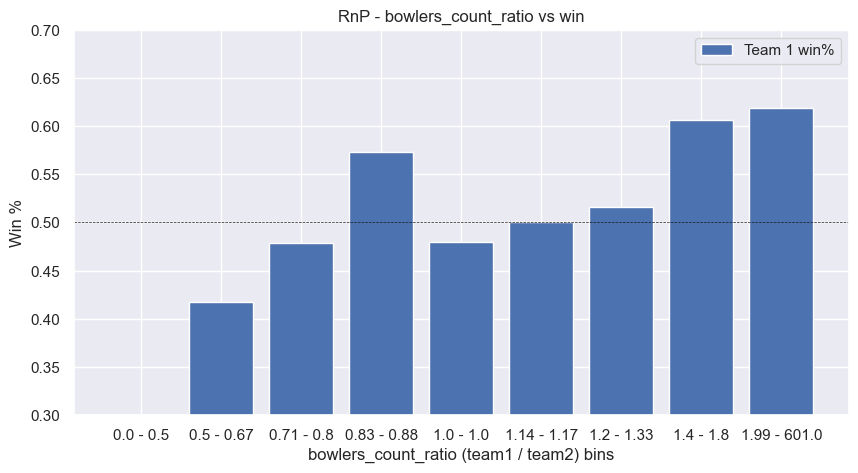

In [382]:
createRnP(train_data,'bowlers_count_ratio', N=10)

In [336]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

              precision    recall  f1-score   support

           0       0.61      0.67      0.63        99
           1       0.59      0.53      0.56        91

    accuracy                           0.60       190
   macro avg       0.60      0.60      0.60       190
weighted avg       0.60      0.60      0.60       190



#Bowler_type


In [337]:
def count_bowlers_by_type(player_list, date, bowler_type):
    '''
    Function to get the count of bowlers of a specific type in the roster of a team before an input date.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. bowler_type: Type of the bowler to count ('fast' or 'spin')
    
    Output-None
    
    Returns- int value denoting count of bowlers of the specified type in the roster.
    '''
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    bowler_count = 0
    for player in player_list: # loop over each player_id in roster
        df_rel = bowlers_data[(bowlers_data['match_dt']<date) & 
                              (bowlers_data['bowler_id']==float(player)) & 
                              (bowlers_data['bowler_details'].str.contains(bowler_type, case=False))] # filter by date and bowler type
        if not df_rel.empty:
            bowler_count += 1
    return bowler_count

# Apply the function to calculate bowler counts by type for team1 and team2
train_data['team1_fast_bowlers_count'] = train_data.progress_apply(lambda x: count_bowlers_by_type(x['team1_roster_ids'], x['match_dt'], 'fast'), axis=1)
train_data['team2_fast_bowlers_count'] = train_data.progress_apply(lambda x: count_bowlers_by_type(x['team2_roster_ids'], x['match_dt'], 'fast'), axis=1)
train_data['team1_spin_bowlers_count'] = train_data.progress_apply(lambda x: count_bowlers_by_type(x['team1_roster_ids'], x['match_dt'], 'spin'), axis=1)
train_data['team2_spin_bowlers_count'] = train_data.progress_apply(lambda x: count_bowlers_by_type(x['team2_roster_ids'], x['match_dt'], 'spin'), axis=1)

# Calculate the ratios of bowler counts by type
train_data['fast_bowlers_count_ratio'] = (train_data['team1_fast_bowlers_count'] + 1e-2) / (train_data['team2_fast_bowlers_count'] + 1e-2)
train_data['spin_bowlers_count_ratio'] = (train_data['team1_spin_bowlers_count'] + 1e-2) / (train_data['team2_spin_bowlers_count'] + 1e-2)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_fast_bowlers_count', 'team2_fast_bowlers_count', 'team1_spin_bowlers_count', 'team2_spin_bowlers_count'], inplace=True)



100%|██████████| 948/948 [06:26<00:00,  2.46it/s]


In [338]:
test_data['team1_fast_bowlers_count'] = test_data.progress_apply(lambda x: count_bowlers_by_type(x['team1_roster_ids'], x['match_dt'], 'fast'), axis=1)
test_data['team2_fast_bowlers_count'] = test_data.progress_apply(lambda x: count_bowlers_by_type(x['team2_roster_ids'], x['match_dt'], 'fast'), axis=1)
test_data['team1_spin_bowlers_count'] = test_data.progress_apply(lambda x: count_bowlers_by_type(x['team1_roster_ids'], x['match_dt'], 'spin'), axis=1)
test_data['team2_spin_bowlers_count'] = test_data.progress_apply(lambda x: count_bowlers_by_type(x['team2_roster_ids'], x['match_dt'], 'spin'), axis=1)

# Calculate the ratios of bowler counts by type
test_data['fast_bowlers_count_ratio'] = (test_data['team1_fast_bowlers_count'] + 1e-2) / (test_data['team2_fast_bowlers_count'] + 1e-2)
test_data['spin_bowlers_count_ratio'] = (test_data['team1_spin_bowlers_count'] + 1e-2) / (test_data['team2_spin_bowlers_count'] + 1e-2)

# Drop intermediate columns if needed
test_data.drop(columns=['team1_fast_bowlers_count', 'team2_fast_bowlers_count', 'team1_spin_bowlers_count', 'team2_spin_bowlers_count'], inplace=True)



100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


In [376]:
train_data.drop(['fast_bowlers_count_ratio','spin_bowlers_count_ratio'],axis=1,inplace=True)
test_data.drop(['fast_bowlers_count_ratio','spin_bowlers_count_ratio'],axis=1,inplace=True)

slope: 0.49 / 0.41 =  1.22


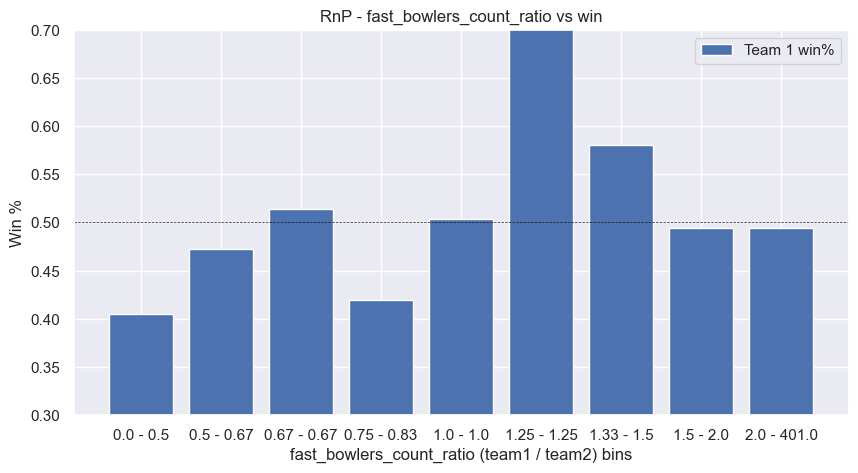

slope: 0.51 / 0.51 =  1.01


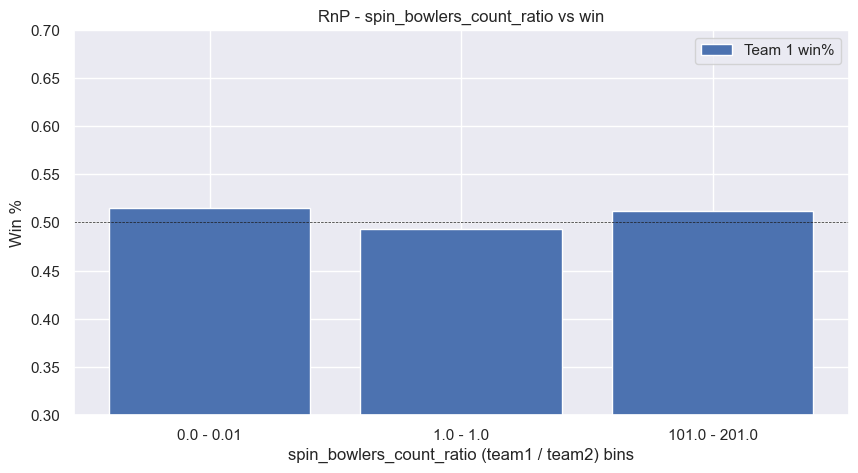

In [339]:
createRnP(train_data,'fast_bowlers_count_ratio', N=10)
createRnP(train_data,'spin_bowlers_count_ratio', N=10)

In [340]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

              precision    recall  f1-score   support

           0       0.59      0.64      0.61        99
           1       0.57      0.53      0.55        91

    accuracy                           0.58       190
   macro avg       0.58      0.58      0.58       190
weighted avg       0.58      0.58      0.58       190



#Chasing_Accuracy

In [342]:
def chasing_win_percentage(team_id, date):
    """
    Calculate the win percentage of a team when they are chasing.
    """
    df_chasing = match_data[(match_data['match_dt'] < date) &
                            ((match_data['team1_id'] == team_id) & (match_data['toss decision'] == 'field') |
                             (match_data['team2_id'] == team_id) & (match_data['toss decision'] == 'bat'))]
    
    win_count = df_chasing[df_chasing['winner_id'] == team_id].shape[0]
    total_chasing_games = df_chasing.shape[0]
    
    if total_chasing_games == 0:
        return 0
    
    return (win_count / total_chasing_games) * 100

def not_chasing_win_percentage(team_id, date):
    """
    Calculate the win percentage of a team when they are not chasing.
    """
    df_not_chasing = match_data[(match_data['match_dt'] < date) &
                                ((match_data['team1_id'] == team_id) & (match_data['toss decision'] == 'bat') |
                                 (match_data['team2_id'] == team_id) & (match_data['toss decision'] == 'field'))]
    
    win_count = df_not_chasing[df_not_chasing['winner_id'] == team_id].shape[0]
    total_not_chasing_games = df_not_chasing.shape[0]
    
    if total_not_chasing_games == 0:
        return 0
    
    return (win_count / total_not_chasing_games) * 100

# Adding the feature to train_data
train_data['team1_chasing_win_percent'] = train_data.apply(lambda x: chasing_win_percentage(x['team1_id'], x['match_dt']), axis=1)
train_data['team2_not_chasing_win_percent'] = train_data.apply(lambda x: not_chasing_win_percentage(x['team2_id'], x['match_dt']), axis=1)

# Calculate the ratio based on the toss decision
train_data['chasing_win_percent_ratio'] = train_data.apply(lambda x: ((x['team1_chasing_win_percent']+0.1) / (x['team2_not_chasing_win_percent']+0.1)) 
                                                           if x['toss decision'] == 'field' else ((x['team2_not_chasing_win_percent']+0.01) / (x['team1_chasing_win_percent']+0.1)), axis=1)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_chasing_win_percent', 'team2_not_chasing_win_percent'], inplace=True)

In [343]:
# Adding the feature to train_data
test_data['team1_chasing_win_percent'] = test_data.apply(lambda x: chasing_win_percentage(x['team1_id'], x['match_dt']), axis=1)
test_data['team2_not_chasing_win_percent'] = test_data.apply(lambda x: not_chasing_win_percentage(x['team2_id'], x['match_dt']), axis=1)

# Calculate the ratio based on the toss decision
test_data['chasing_win_percent_ratio'] = test_data.apply(lambda x: ((x['team1_chasing_win_percent']+0.1) / (x['team2_not_chasing_win_percent']+0.1)) 
                                                           if x['toss decision'] == 'field' else ((x['team2_not_chasing_win_percent']+0.01) / (x['team1_chasing_win_percent']+0.1)), axis=1)

# Drop intermediate columns if needed
test_data.drop(columns=['team1_chasing_win_percent', 'team2_not_chasing_win_percent'], inplace=True)

In [375]:
train_data.drop('chasing_win_percent_ratio',axis=1, inplace=True)
test_data.drop('chasing_win_percent_ratio',axis=1, inplace=True)

slope: 0.47 / 0.47 =  1.01


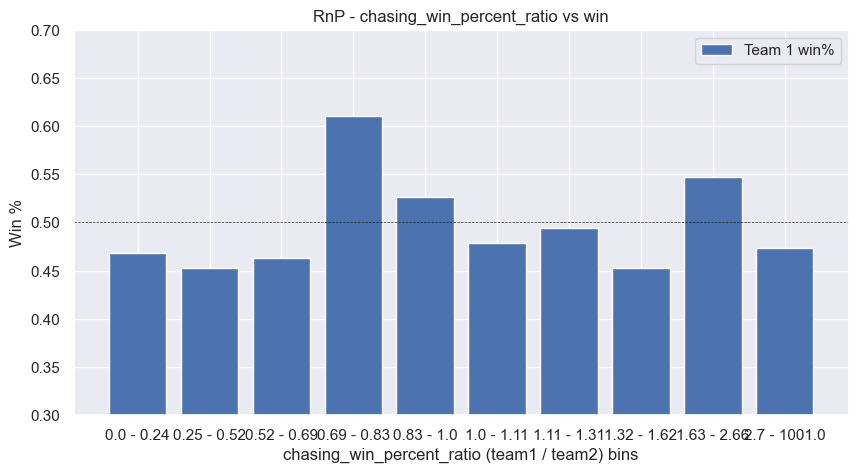

In [344]:
createRnP(train_data,'chasing_win_percent_ratio', N=10)

In [345]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

              precision    recall  f1-score   support

           0       0.60      0.63      0.61        99
           1       0.57      0.54      0.55        91

    accuracy                           0.58       190
   macro avg       0.58      0.58      0.58       190
weighted avg       0.58      0.58      0.58       190



## Based on Lighting

In [677]:
def player_win_rate_based_on_lighting(player_id, lighting, date):
    """
    Calculate the win percentage of a player based on the lighting condition.
    """
    df_player = match_data[(match_data['match_dt'] < date) &
                           ((match_data['team1_roster_ids'].str.contains(player_id)) |
                            (match_data['team2_roster_ids'].str.contains(player_id))) &
                           (match_data['lighting'] == lighting)]
    
    win_count = df_player[(df_player['winner_id'] == df_player['team1_id']) & (df_player['team1_roster_ids'].str.contains(player_id))].shape[0] + \
                df_player[(df_player['winner_id'] == df_player['team2_id']) & (df_player['team2_roster_ids'].str.contains(player_id))].shape[0]
    total_games = df_player.shape[0]
    
    if total_games == 0:
        return 0
    
    return (win_count / total_games) * 100

def team_average_win_rate_based_on_lighting(player_list, lighting, date):
    """
    Calculate the average win rate for a team based on the players' win rates under the specific lighting condition.
    """
    player_list = str(player_list).split(':')
    win_rates = [player_win_rate_based_on_lighting(player_id, lighting, date) for player_id in player_list]
    return sum(win_rates) / len(win_rates) if win_rates else 0

# Adding the feature to train_data
train_data['team1_avg_win_rate_lighting'] = train_data.progress_apply(lambda x: team_average_win_rate_based_on_lighting(x['team1_roster_ids'], x['lighting'], x['match_dt']), axis=1)
train_data['team2_avg_win_rate_lighting'] = train_data.progress_apply(lambda x: team_average_win_rate_based_on_lighting(x['team2_roster_ids'], x['lighting'], x['match_dt']), axis=1)

# Calculate the ratio
train_data['win_rate_lighting_ratio'] = (train_data['team1_avg_win_rate_lighting']+0.1) /(train_data['team2_avg_win_rate_lighting'] +0.1)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_avg_win_rate_lighting', 'team2_avg_win_rate_lighting'], inplace=True)

# Repeat the same process for the test data
test_data['team1_avg_win_rate_lighting'] = test_data.apply(lambda x: team_average_win_rate_based_on_lighting(x['team1_roster_ids'], x['lighting'], x['match_dt']), axis=1)
test_data['team2_avg_win_rate_lighting'] = test_data.apply(lambda x: team_average_win_rate_based_on_lighting(x['team2_roster_ids'], x['lighting'], x['match_dt']), axis=1)

# Calculate the ratio
test_data['win_rate_lighting_ratio'] = test_data['team1_avg_win_rate_lighting'] / test_data['team2_avg_win_rate_lighting']

# Drop intermediate columns if needed
test_data.drop(columns=['team1_avg_win_rate_lighting', 'team2_avg_win_rate_lighting'], inplace=True)


  0%|          | 0/948 [00:00<?, ?it/s]

100%|██████████| 948/948 [01:17<00:00, 12.15it/s]


slope: 0.64 / 0.39 =  1.63


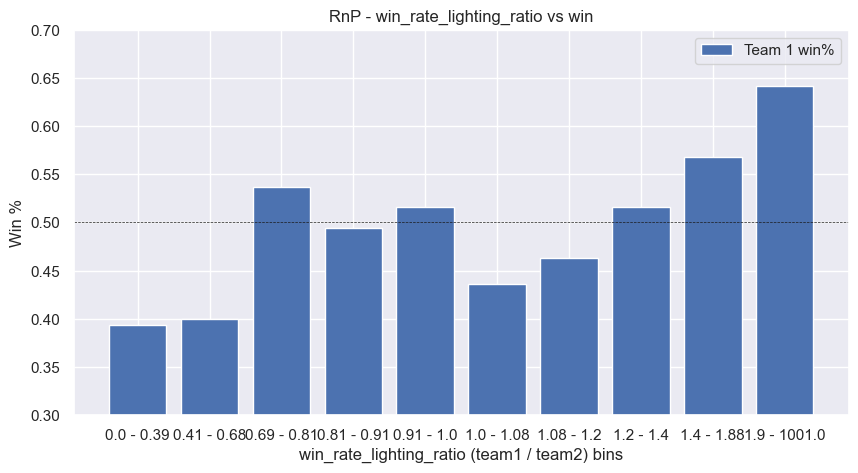

In [678]:
createRnP(train_data,'win_rate_lighting_ratio', N=10)

In [679]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.57591623 0.54644809 0.60512821 0.5483871  0.51578947]
              precision    recall  f1-score   support

           0       0.57      0.58      0.58        96
           1       0.57      0.55      0.56        94

    accuracy                           0.57       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.57      0.57      0.57       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Winning based on Stress

In [680]:
def calculate_stress_matches(match_data):
    """
    Identify stress matches based on the criteria provided.
    """
    stress_matches = match_data[
        ((match_data['inning2_runs'] <= match_data['inning1_runs'] + 10) & (match_data['inning2_runs'] >= match_data['inning1_runs'] - 10)) |
        (match_data['inning2_wickets'] <= 2)
    ]
    return stress_matches

def win_percentage_in_stress(team_id, date, stress_matches):
    """
    Calculate the win percentage for a team in stress matches before a given date.
    """
    df_team = stress_matches[
        (stress_matches['match_dt'] < date) & 
        ((stress_matches['team1_id'] == team_id) | (stress_matches['team2_id'] == team_id))
    ]
    win_count = df_team[df_team['winner_id'] == team_id].shape[0]
    total_matches = df_team.shape[0]
    
    if total_matches == 0:
        return 0
    
    return (win_count / total_matches) * 100

# Identify stress matches in the match_data
stress_matches = calculate_stress_matches(match_data)

# Adding the feature to train_data
train_data['team1_win_percent_stress'] = train_data.progress_apply(lambda x: win_percentage_in_stress(x['team1_id'], x['match_dt'], stress_matches), axis=1)
train_data['team2_win_percent_stress'] = train_data.progress_apply(lambda x: win_percentage_in_stress(x['team2_id'], x['match_dt'], stress_matches), axis=1)

# Calculate the ratio
train_data['win_percent_stress_ratio'] = (train_data['team1_win_percent_stress'] +0.1) / (train_data['team2_win_percent_stress']+0.1)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_win_percent_stress', 'team2_win_percent_stress'], inplace=True)

# Repeat the same process for the test data
test_data['team1_win_percent_stress'] = test_data.progress_apply(lambda x: win_percentage_in_stress(x['team1_id'], x['match_dt'], stress_matches), axis=1)
test_data['team2_win_percent_stress'] = test_data.progress_apply(lambda x: win_percentage_in_stress(x['team2_id'], x['match_dt'], stress_matches), axis=1)

# Calculate the ratio
test_data['win_percent_stress_ratio'] = test_data['team1_win_percent_stress'] / test_data['team2_win_percent_stress']

# Drop intermediate columns if needed
test_data.drop(columns=['team1_win_percent_stress', 'team2_win_percent_stress'], inplace=True)


100%|██████████| 271/271 [00:00<00:00, 650.79it/s]


slope: 0.57 / 0.41 =  1.38


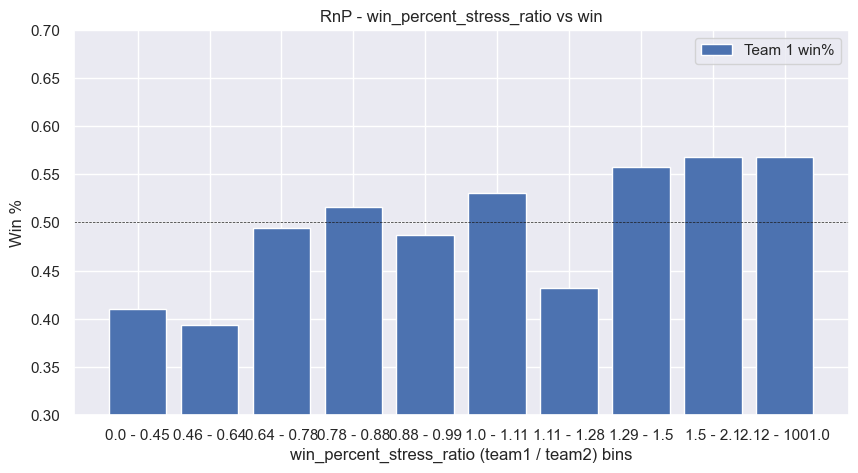

In [681]:
createRnP(train_data,'win_percent_stress_ratio', N=10)

In [682]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.57591623 0.54644809 0.60512821 0.5483871  0.51578947]
              precision    recall  f1-score   support

           0       0.60      0.67      0.64        95
           1       0.63      0.56      0.59        95

    accuracy                           0.62       190
   macro avg       0.62      0.62      0.61       190
weighted avg       0.62      0.62      0.61       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Batting Consistency

In [683]:
# Helper function to calculate batting consistency for a player
def batting_consistency(player_id, date, n):
    player_stats = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bat')
    if player_stats.empty:
        return np.nan
    return np.std(player_stats['runs'])

# Helper function to calculate team batting consistency
def team_batting_consistency(player_list, date, n):
    player_list = str(player_list).split(':')
    consistencies = [batting_consistency(player, date, n) for player in player_list]
    consistencies = [c for c in consistencies if not np.isnan(c)]
    if len(consistencies) == 0:
        return np.nan
    return np.mean(consistencies)

# Apply the functions to the train data
train_data['team1_batting_consistency'] = train_data.progress_apply(lambda x: team_batting_consistency(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
train_data['team2_batting_consistency'] = train_data.progress_apply(lambda x: team_batting_consistency(x['team2_roster_ids'], x['match_dt'], 15), axis=1)

# Calculate the ratio of batting consistency
train_data['batting_consistency_ratio'] = (train_data['team1_batting_consistency']+0.1) / (train_data['team2_batting_consistency']+0.1)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_batting_consistency', 'team2_batting_consistency'], inplace=True)

# Repeat the same process for the test data
test_data['team1_batting_consistency'] = test_data.progress_apply(lambda x: team_batting_consistency(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
test_data['team2_batting_consistency'] = test_data.progress_apply(lambda x: team_batting_consistency(x['team2_roster_ids'], x['match_dt'], 15), axis=1)

# Calculate the ratio of batting consistency
test_data['batting_consistency_ratio'] = test_data['team1_batting_consistency'] / test_data['team2_batting_consistency']

# Drop intermediate columns if needed
test_data.drop(columns=['team1_batting_consistency', 'team2_batting_consistency'], inplace=True)

100%|██████████| 271/271 [00:12<00:00, 21.21it/s]


slope: 0.58 / 0.37 =  1.57


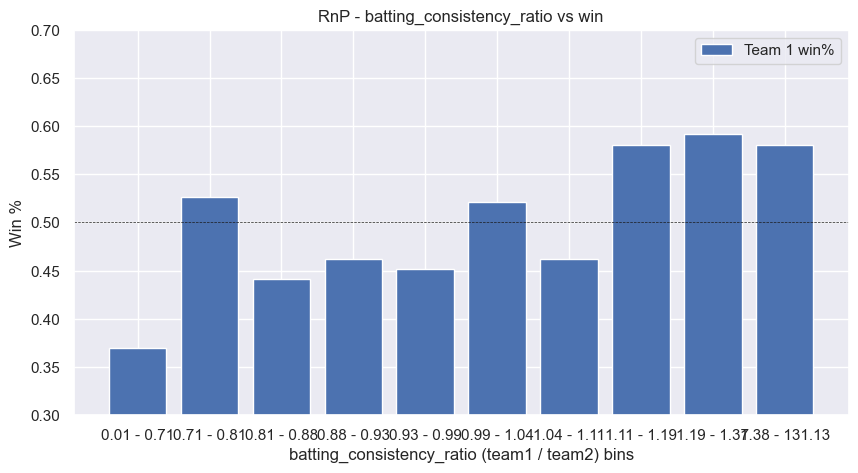

In [684]:
createRnP(train_data,'batting_consistency_ratio', N=10)

In [685]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.57591623 0.54644809 0.60512821 0.5483871  0.51578947]
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       101
           1       0.52      0.55      0.53        89

    accuracy                           0.55       190
   macro avg       0.55      0.55      0.55       190
weighted avg       0.55      0.55      0.55       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Bowler Consistency

In [686]:
def is_bowler(player_id, date):
    player_stats = bowlers_data[(bowlers_data['match_dt'] < date) & (bowlers_data['bowler_id'] == float(player_id))]
    total_overs = player_stats['balls_bowled'].sum() / 6
    return total_overs >= 10

# Helper function to calculate bowling consistency for a bowler
def bowling_consistency(player_id, date, n):
    if not is_bowler(player_id, date):
        return np.nan
    player_stats = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
    if player_stats.empty:
        return np.nan
    return np.std(player_stats['runs'])

# Helper function to calculate team bowling consistency
def team_bowling_consistency(player_list, date, n):
    player_list = str(player_list).split(':')
    consistencies = [bowling_consistency(player, date, n) for player in player_list]
    consistencies = [c for c in consistencies if not np.isnan(c)]
    if len(consistencies) == 0:
        return np.nan
    return np.mean(consistencies)

# Apply the functions to the train data
train_data['team1_bowling_consistency'] = train_data.progress_apply(lambda x: team_bowling_consistency(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
train_data['team2_bowling_consistency'] = train_data.progress_apply(lambda x: team_bowling_consistency(x['team2_roster_ids'], x['match_dt'], 15), axis=1)

# Calculate the ratio of bowling consistency
train_data['bowling_consistency_ratio'] = (train_data['team1_bowling_consistency'] + 0.1) / (train_data['team2_bowling_consistency'] + 0.1)

# Drop intermediate columns if needed
train_data.drop(columns=['team1_bowling_consistency', 'team2_bowling_consistency'], inplace=True)

# Repeat the same process for the test data
test_data['team1_bowling_consistency'] = test_data.progress_apply(lambda x: team_bowling_consistency(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
test_data['team2_bowling_consistency'] = test_data.progress_apply(lambda x: team_bowling_consistency(x['team2_roster_ids'], x['match_dt'], 15), axis=1)

# Calculate the ratio of bowling consistency
test_data['bowling_consistency_ratio'] = (test_data['team1_bowling_consistency'] + 0.1) / (test_data['team2_bowling_consistency'] + 0.1)

# Drop intermediate columns if needed
test_data.drop(columns=['team1_bowling_consistency', 'team2_bowling_consistency'], inplace=True)

100%|██████████| 271/271 [00:15<00:00, 17.85it/s]


slope: 0.56 / 0.44 =  1.27


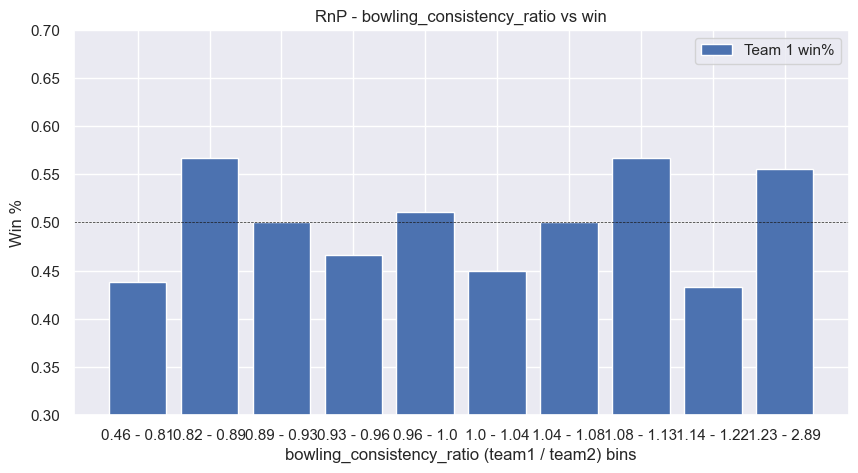

In [687]:
createRnP(train_data,'bowling_consistency_ratio', N=10)

In [688]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.59893048 0.55434783 0.53968254 0.56521739 0.50515464]
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        96
           1       0.52      0.56      0.54        94

    accuracy                           0.53       190
   macro avg       0.53      0.53      0.53       190
weighted avg       0.53      0.53      0.53       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Catch efficiency

In [696]:
def get_total_catches(player_list, date, n=10):
    '''
    Function to calculate the total number of catches by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of catches by all players in the roster.
    '''
    player_list = str(player_list).split(':')  # split string of ':' separated ids into a list of ids
    total_catches = 0
    for player in player_list:  # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')  # getting fielding stats from last n games for each player.
        total_catches += df_rel[df_rel['wicket kind'] == 'caught'].shape[0]  # Sum up number of catches for the player
    return total_catches

# Applying the feature to the train and test datasets
def apply_catch_feature(data):
    tqdm.pandas()
    data['team1_catches'] = data.progress_apply(lambda x: get_total_catches(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_catches'] = data.progress_apply(lambda x: get_total_catches(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['catch_ratio'] = (data['team1_catches'] + 1e-2) / (data['team2_catches'] + 1e-2)
    
    # Dropping intermediate columns if needed
    data.drop(columns=['team1_catches', 'team2_catches'], inplace=True)
    
    return data

# Assuming train_data and test_data are your DataFrames
train_data = apply_catch_feature(train_data)
test_data = apply_catch_feature(test_data)

100%|██████████| 271/271 [00:12<00:00, 21.28it/s]


slope: 0.53 / 0.28 =  1.92


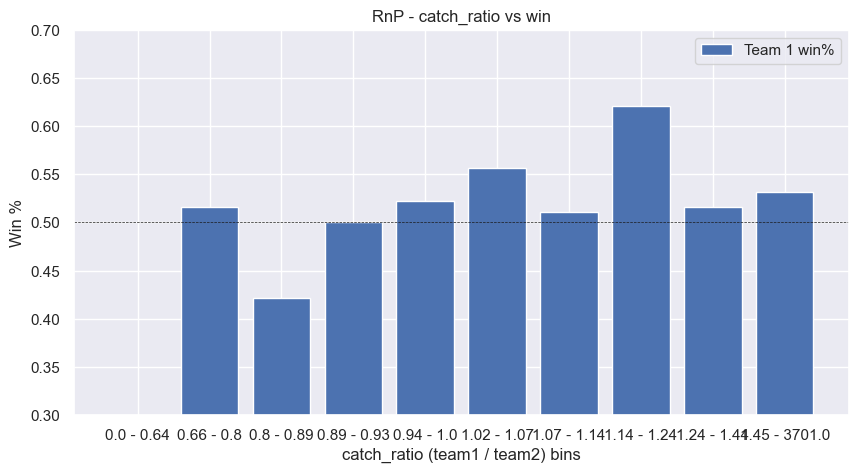

In [697]:
createRnP(train_data,'catch_ratio', N=10)

In [698]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.57608696 0.53608247 0.50793651 0.57142857 0.51336898]
              precision    recall  f1-score   support

           0       0.59      0.66      0.63       100
           1       0.57      0.50      0.53        90

    accuracy                           0.58       190
   macro avg       0.58      0.58      0.58       190
weighted avg       0.58      0.58      0.58       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [694]:
batsman_data['wicket kind'].value_counts()

wicket kind
caught               12263
bowled                3323
lbw                   1287
run out               1159
caught and bowled      574
stumped                489
retired hurt            31
hit wicket              20
retired out              6
retired not out          3
Name: count, dtype: int64

## Runout efficiency

In [699]:
def get_total_runouts(player_list, date, n=10):
    '''
    Function to calculate the total number of run-outs by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of run-outs by all players in the roster.
    '''
    player_list = str(player_list).split(':')  # split string of ':' separated ids into a list of ids
    total_runouts = 0
    for player in player_list:  # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')  # getting fielding stats from last n games for each player.
        total_runouts += df_rel[df_rel['wicket kind'] == 'run out'].shape[0]  # Sum up number of run-outs for the player
    return total_runouts

# Applying the feature to the train and test datasets
def apply_runout_feature(data):
    tqdm.pandas()
    data['team1_runouts'] = data.progress_apply(lambda x: get_total_runouts(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_runouts'] = data.progress_apply(lambda x: get_total_runouts(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['runout_ratio'] = (data['team1_runouts'] + 1e-2) / (data['team2_runouts'] + 1e-2)
    
    # Dropping intermediate columns if needed
    data.drop(columns=['team1_runouts', 'team2_runouts'], inplace=True)
    
    return data

# Assuming train_data and test_data are your DataFrames
train_data = apply_runout_feature(train_data)
test_data = apply_runout_feature(test_data)

100%|██████████| 948/948 [00:48<00:00, 19.67it/s]


slope: 0.52 / 0.4 =  1.3


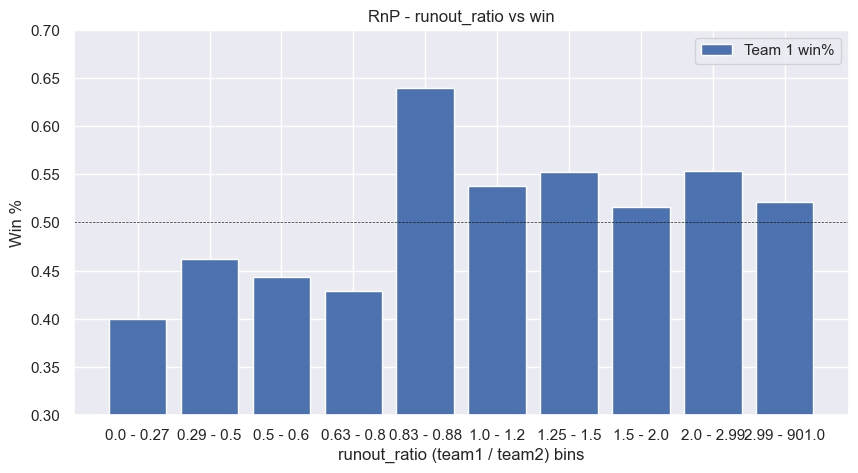

In [700]:
createRnP(train_data,'runout_ratio', N=10)

In [701]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.57458564 0.57291667 0.57       0.6        0.4973545 ]
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       100
           1       0.54      0.60      0.57        90

    accuracy                           0.57       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.57      0.57      0.57       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## out by keeper

In [702]:
def get_total_outs_by_keeper(player_list, date, n=10):
    '''
    Function to calculate the total number of outs by keeper (caught by keeper and stumped) for players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of outs by keeper for all players in the roster.
    '''
    player_list = str(player_list).split(':')  # split string of ':' separated ids into a list of ids
    total_outs_by_keeper = 0
    for player in player_list:  # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')  # getting batting stats from last n games for each player.
        if df_rel.shape[0] >= 10:  # Only consider players who have played at least 10 matches
            total_outs_by_keeper += df_rel[(df_rel['wicket kind'] == 'caught') & (df_rel['out_by_fielder'] == 'keeper')].shape[0]
            total_outs_by_keeper += df_rel[df_rel['wicket kind'] == 'stumped'].shape[0]  # Include stumped dismissals
    return total_outs_by_keeper

# Applying the feature to the train and test datasets
def apply_outs_by_keeper_feature(data):
    tqdm.pandas()
    data['team1_outs_by_keeper'] = data.progress_apply(lambda x: get_total_outs_by_keeper(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_outs_by_keeper'] = data.progress_apply(lambda x: get_total_outs_by_keeper(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['outs_by_keeper_ratio'] = (data['team1_outs_by_keeper'] + 1e-2) / (data['team2_outs_by_keeper'] + 1e-2)
    
    # Dropping intermediate columns if needed
    data.drop(columns=['team1_outs_by_keeper', 'team2_outs_by_keeper'], inplace=True)
    
    return data

# Assuming train_data and test_data are your DataFrames
train_data = apply_outs_by_keeper_feature(train_data)
test_data = apply_outs_by_keeper_feature(test_data)

100%|██████████| 948/948 [00:51<00:00, 18.40it/s]


slope: 0.55 / 0.54 =  1.02


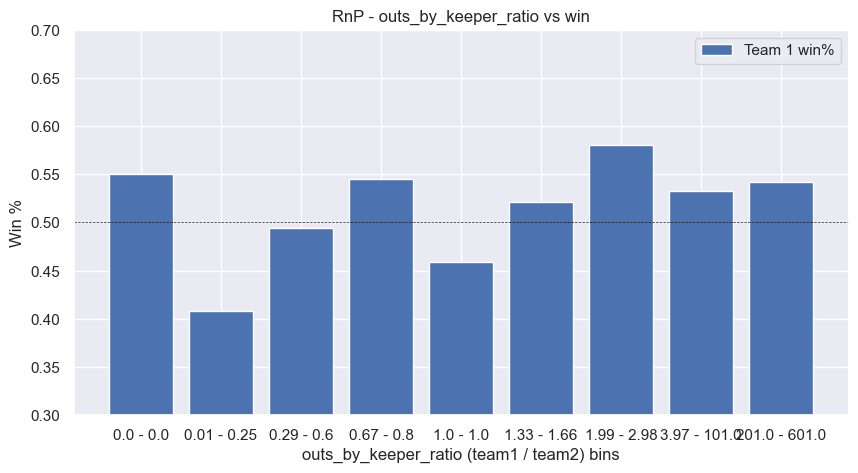

In [703]:
createRnP(train_data,'outs_by_keeper_ratio', N=10)

In [704]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.6031746  0.55670103 0.53465347 0.55384615 0.55865922]
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        94
           1       0.52      0.46      0.49        96

    accuracy                           0.51       190
   macro avg       0.51      0.51      0.51       190
weighted avg       0.51      0.51      0.51       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## total fielder stats

In [711]:
def get_total_catches(player_list, date, n=10):
    player_list = str(player_list).split(':')
    total_catches = 0
    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        if df_rel.shape[0] >= 10:
            catches = df_rel[df_rel['wicket kind'] == 'caught']['wicket kind'].count()
            total_catches += catches
    return total_catches

# Function to calculate total run-outs by fielders
def get_total_runouts(player_list, date, n=10):
    player_list = str(player_list).split(':')
    total_runouts = 0
    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        if df_rel.shape[0] >= 10:
            runouts = df_rel[df_rel['wicket kind'] == 'run out']['wicket kind'].count()
            total_runouts += runouts
    return total_runouts

# Function to calculate total stumpings by keeper
def get_total_stumpings(player_list, date, n=10):
    player_list = str(player_list).split(':')
    total_stumpings = 0
    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        if df_rel.shape[0] >= 10:
            stumpings = df_rel[df_rel['wicket kind'] == 'stumped']['wicket kind'].count()
            total_stumpings += stumpings
    return total_stumpings



# Function to calculate total fielder dismissals (catches + run-outs + stumpings)
def get_total_fielder_dismissals(player_list, date, n=10):
    player_list = str(player_list).split(':')
    total_dismissals = 0
    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        if df_rel.shape[0] >= 10:
            dismissals = df_rel[(df_rel['wicket kind'] == 'caught') | (df_rel['wicket kind'] == 'run out') | (df_rel['wicket kind'] == 'stumped')]['wicket kind'].count()
            total_dismissals += dismissals
    return total_dismissals

# Applying the features to the train and test datasets
def apply_fielder_features(data):
    tqdm.pandas()
    data['team1_catches'] = data.progress_apply(lambda x: get_total_catches(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_catches'] = data.progress_apply(lambda x: get_total_catches(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['catch_ratio'] = (data['team1_catches'] + 1e-2) / (data['team2_catches'] + 1e-2)

    data['team1_runouts'] = data.progress_apply(lambda x: get_total_runouts(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_runouts'] = data.progress_apply(lambda x: get_total_runouts(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['runout_ratio'] = (data['team1_runouts'] + 1e-2) / (data['team2_runouts'] + 1e-2)

    data['team1_stumpings'] = data.progress_apply(lambda x: get_total_stumpings(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_stumpings'] = data.progress_apply(lambda x: get_total_stumpings(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['stumping_ratio'] = (data['team1_stumpings'] + 1e-2) / (data['team2_stumpings'] + 1e-2)

    data['team1_fielder_dismissals'] = data.progress_apply(lambda x: get_total_fielder_dismissals(x['team1_roster_ids'], x['match_dt']), axis=1)
    data['team2_fielder_dismissals'] = data.progress_apply(lambda x: get_total_fielder_dismissals(x['team2_roster_ids'], x['match_dt']), axis=1)
    data['fielder_dismissal_ratio'] = (data['team1_fielder_dismissals'] + 1e-2) / (data['team2_fielder_dismissals'] + 1e-2)
    
    # Dropping intermediate columns if needed
    data.drop(columns=['team1_catches', 'team2_catches', 'team1_runouts', 'team2_runouts', 'team1_stumpings', 'team2_stumpings',
                        'team1_fielder_dismissals', 'team2_fielder_dismissals'], inplace=True)
    
    return data

# Assuming train_data and test_data are your DataFrames
train_data = apply_fielder_features(train_data)
#test_data = apply_fielder_features(test_data)

100%|██████████| 948/948 [00:20<00:00, 46.17it/s]


slope: 0.64 / 0.27 =  2.41


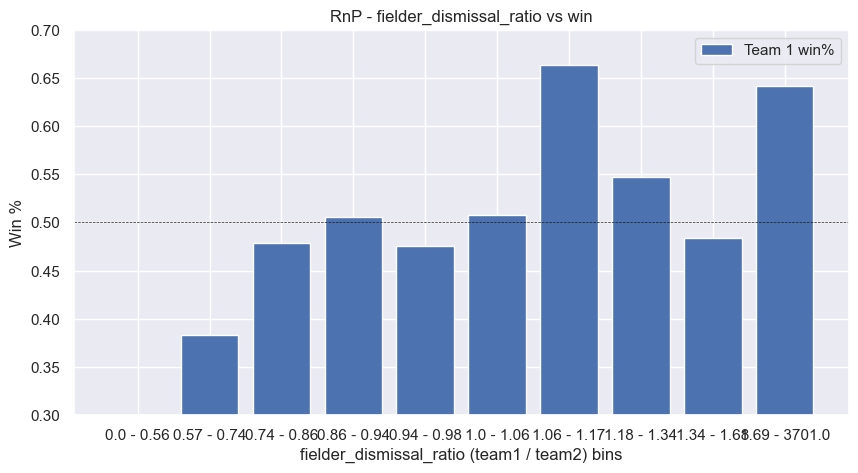

slope: 0.58 / 0.37 =  1.55


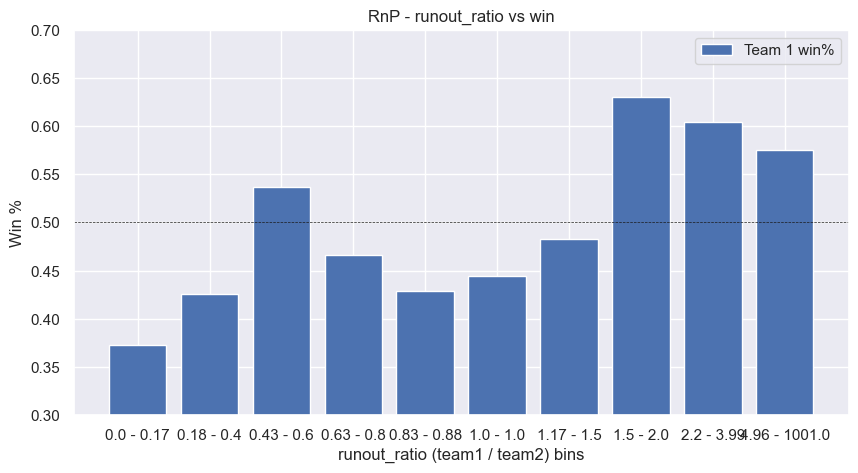

slope: 0.55 / 0.54 =  1.02


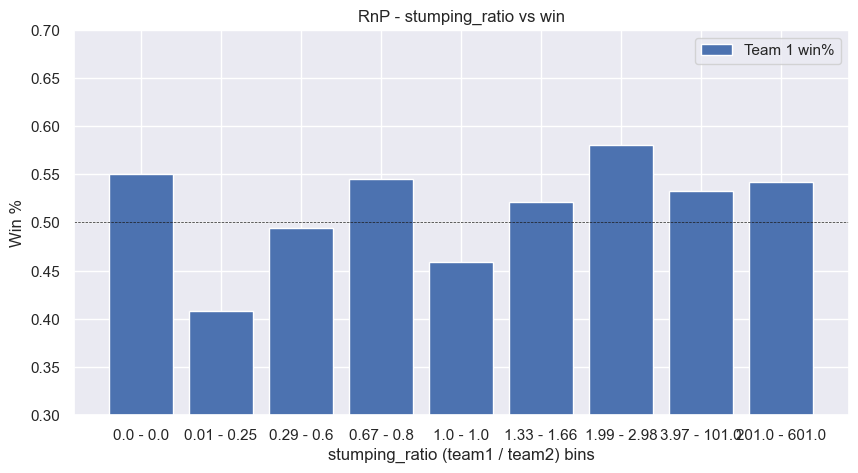

slope: 0.64 / 0.26 =  2.51


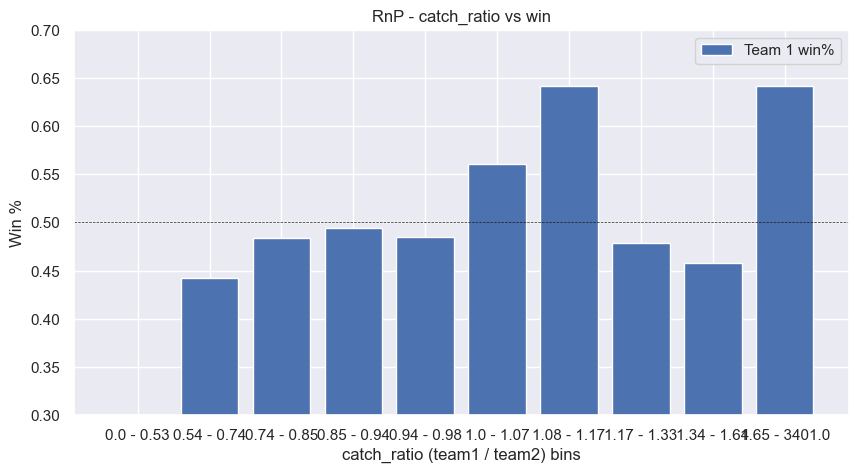

In [712]:
createRnP(train_data,'fielder_dismissal_ratio', N=10)
createRnP(train_data,'runout_ratio', N=10)
createRnP(train_data,'stumping_ratio', N=10)
createRnP(train_data,'catch_ratio', N=10)



In [713]:
preprocess_and_train(train_data, depth=4,lr=0.1,n_trees=50)

[0.53191489 0.62105263 0.56084656 0.60512821 0.53684211]
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        94
           1       0.59      0.60      0.60        96

    accuracy                           0.59       190
   macro avg       0.59      0.59      0.59       190
weighted avg       0.59      0.59      0.59       190



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Submission

In [644]:
model = preprocess_and_train(train_data, gridsearch=True ,n_trees=13,depth=2,lr=0.1)
X,y_t = get_data_ready(train_data, True)
X_test = get_data_ready(test_data, False)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=3;, score=0.700 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=3;, score=0.705 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=3;, score=0.674 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=3;, score=0.656 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=3;, score=0.608 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=5;, score=0.679 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=5;, score=0.737 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=5;, score=0.674 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=5;, score=0.656 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=5;, score=0.608 total time=   0

KeyboardInterrupt: 

In [659]:
X,y_t = get_data_ready(train_data, True)
X_test = get_data_ready(test_data, False)
model = preprocess_and_train(train_data, gridsearch=False ,depth=2, eta=0.05,colsample_bytree=0.3,num_boosting_rounds=20)
#model = GradientBoostingClassifier(learning_rate=1.1, max_depth=4, n_estimators=10)
print(cross_val_score(model,X,y_t,cv=10,scoring='f1').mean())

[0.59259259 0.56179775 0.57731959 0.5625     0.54358974]
              precision    recall  f1-score   support

           0       0.56      0.64      0.60        92
           1       0.61      0.53      0.57        98

    accuracy                           0.58       190
   macro avg       0.59      0.59      0.58       190
weighted avg       0.59      0.58      0.58       190

0.568778628754902


In [647]:
X.columns

Index(['team1_id', 'team2_id', 'ground_id', 'team_count_50runs_last15',
       'team_winp_last5', 'team1only_avg_runs_last15',
       'team1_winp_team2_last15', 'ground_avg_runs_last15',
       'team_avg_runs_last15', 'ground_diff_runs_last15', 'ground_avg_wickets',
       'matches_ratio_team1_team2', 'avg_recent_runs_ratio',
       'avg_recent_wickets_ratio', 'batsmen_count_ratio',
       'toss_win_rate_ratio', 'bowlers_count_ratio', 'y_pred_01',
       'win_pred_score', 'win_pred_team_id', 'win_rate_lighting_ratio'],
      dtype='object')

In [ ]:
train_data_copy = train_data.copy(deep=True)
test_data_copy = test_data.copy(deep=True)

In [ ]:
X_test.columns 

Index(['team1_id', 'team2_id', 'ground_id', 'team_count_50runs_last15',
       'team_winp_last5', 'team1only_avg_runs_last15',
       'team1_winp_team2_last15', 'ground_avg_runs_last15',
       'team_avg_runs_last15', 'ground_diff_runs_last15', 'ground_avg_wickets',
       'matches_ratio_team1_team2', 'avg_recent_runs_ratio',
       'avg_recent_wickets_ratio', 'bowlers_count_ratio',
       'batsmen_count_ratio', 'toss_win_rate_ratio'],
      dtype='object')

In [ ]:
X.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False])

In [ ]:
X_test = X_test[X.columns]

In [648]:
#train_data.drop('y_pred_01',axis=1,inplace=True)
#test_data.drop('y_pred_01',axis=1,inplace=True)

train_data.drop(['y_pred_01','win_pred_score','win_pred_team_id'],axis = 1, inplace=True)
test_data.drop(['y_pred_01','win_pred_score','win_pred_team_id'],axis = 1, inplace=True)

In [ ]:

train_data['y_pred_01'] = model.predict(X)
test_data['y_pred_01'] = model.predict(X_test)

train_data['win_pred_score'] = model.predict_proba(X)[:,1]
test_data['win_pred_score'] = model.predict_proba(X_test)[:,1]

train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':model.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                        .reset_index(drop=True).head(10)
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

## refactor

df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))], \
                     train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan
        
df_file1['train_algorithm'] = 'Gradient Boosting'
df_file1['is_ensemble'] = 'no'
df_file1['train_hps_trees'] = 10
df_file1['train_hps_depth'] = 2
df_file1['train_hps_lr'] = 0.1

import random
import string
feature_desc = {'team_count_50runs_last15':'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',\
               'team_winp_last5':'Ratio of team1\'s win % to team2\'s win % in last 5 games',\
               'ground_avg_runs_last15':'average runs scored in the ground in last 15 games',\
               'team1_winp_team2_last15':'Team1\'s win percentage against Team2 in last 15 games',\
               'team1only_avg_runs_last15':'team1\'s avg inning runs in last 15 games',\
                'batsmen_count_ratio':'ratio of batsman count in both teams',\
                'avg_recent_wickets_ratio':'ratio of recent wickets taken by both teams',\
                'team1only_avg_runs_last15':'team1 avg runs in last 15 games',\
                'team2_id':'Identity of team2',\
                'avg_recent_runs_ratio':'avg runs scored by both teams ratio',\
                'team_avg_runs_last15':'avg run by both teams as ratio',\
                'ground_avg_wickets':'Average wickets taken in the ground',\
                'match id':'An feature due to overfitting most probably',\
               'season_num' : 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',\
               'toss_winner_01' : 'Toss winner to numerical - 1 if team2 wins, else 0',\
               'toss_decision_01' : 'Toss decision - categorical - 1 if winner bats, 0 otherwise',\
                'matches_ratio_team1_team2':' Average experience of both teams ratio',\
                  'bowlers_count_ratio':'Ratio of bowler in both team'  }

# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)
df_file1.to_csv('file1.csv', index=False)
df_file2.to_csv('file2.csv')

In [ ]:
df_file2

,feat_name,model_feat_imp_train,feat_rank_train,feat_description
feat_id,,,,
1,batsmen_count_ratio,0.151140,1,ratio of batsman count in both teams
2,matches_ratio_team1_team2,0.102450,2,Average experience of both teams ratio
3,team_count_50runs_last15,0.070799,3,Ratio of number of 50s by players in team1 to ...
4,ground_avg_runs_last15,0.064514,4,average runs scored in the ground in last 15 g...
5,bowlers_count_ratio,0.063866,5,Ratio of bowler in both team
6,ground_avg_wickets,0.057089,6,Average wickets taken in the ground
7,team2_id,0.056389,7,Identity of team2
8,avg_recent_wickets_ratio,0.055046,8,ratio of recent wickets taken by both teams
9,team1_winp_team2_last15,0.053770,9,Team1's win percentage against Team2 in last 1...
